In [87]:
"""
Random forest Experiments AUDSOME Phase 1
Gabriel Iuhasz
"""
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import xgboost as xgb
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from subprocess import check_output
%matplotlib inline

In [88]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [89]:
print("Checking files in data location ...")
# train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [90]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

Setting paths and datasets


In [91]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [92]:
print("Dataset chosen ...")
data = df_anomaly

# Nice print
nice_y = data['target']
data.shape

Dataset chosen ...


(5400, 90)

In [93]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [94]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


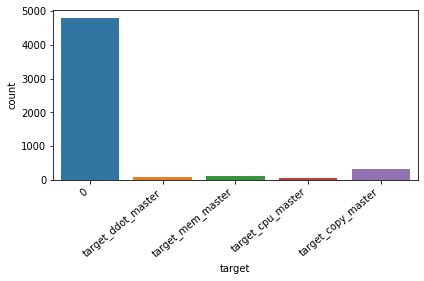

In [95]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [96]:
print("Scaling dataset")
scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df

Scaling dataset


Starting of experiment for RandomForest only

In [97]:
# Name of experiment
# RandomForest
prefix = 'Phase1_RF_EV'
paramgrid = {
    "n_estimators": [10, 50, 100, 200, 300, 500, 1000],
    "max_depth": [5, 10, 25, 50, None],
    "max_features": [5, 10, 20, 30, 50, 60, 85, 'auto'],
    "min_samples_split":[2, 5, 11],
    "min_samples_leaf":[1, 5, 11],
    "criterion": ['entropy', 'gini'],
    "random_state": [42]
}
model = RandomForestClassifier()

In [109]:
#Example of HPO methods https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb
# scorer = make_scorer(accuracy_score, )
scorer = make_scorer(jaccard_score, average="micro") # TODO check average
# scorer = 'accuracy'
n_splits = 4 # default 4

cv_type = StratifiedKFold(n_splits=n_splits)
nj = 10 # Number of jobs

cv = EvolutionaryAlgorithmSearchCV(estimator=model,
                                   params=paramgrid,
                                   scoring=scorer,
                                   cv=cv_type, # StratifiedKFold not supported for multilabel-indicator (oh encoding)
                                   verbose=4,
                                   population_size=40, # 40
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=4,
                                   generations_number=30, #10
                                   n_jobs=nj) # for dnn n_jobs must be set to 1 rest is 8

/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [110]:
cv.fit(X, y)

Types [1, 1, 1, 1, 1, 1, 1] and maxint [6, 4, 8, 2, 2, 1, 0] detected
--- Evolve in 5670 possible combinations ---
[CV] END criterion=entropy, max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=11, n_estimators=10, random_state=42;, score=0.911 total time=   0.2s
[CV] END criterion=entropy, max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=11, n_estimators=10, random_state=42;, score=0.958 total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=10, random_state=42;, score=0.987 total time=   0.6s
[CV] END criterion=entropy, max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=11, n_estimators=10, random_state=42;, score=0.762 total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=11, n_estimators=10, random_state=42;, score=0.948 total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=50

In [111]:
# Remove bool values from dict
cv.cv_results_.pop('nan_test_score?')

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(cv.cv_results_)
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, cv.best_params_))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(cv.best_params_, cvfile)
print("{} best score: {}".format(prefix, cv.best_score_))
print("Saving best {} estimator".format(prefix))
model_name = "{}_hpo_best.joblib".format(prefix)
dump(cv.best_estimator_, os.path.join(model_dir,model_name))

Saving CV results
Phase1_RF_EV best params: {'n_estimators': 10, 'max_depth': None, 'max_features': 20, 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'gini', 'random_state': 42}
Phase1_RF_EV best score: 0.979299698603071
Saving best Phase1_RF_EV estimator


['/home/gabriel/Research/Aspide/workspace/data_phase/models/Phase1_RF_EV_hpo_best.joblib']

In [112]:
y_pred = cv.best_estimator_.predict(X)
custom_scoring_reporting(y_pred, y, definitions, prefix)


Accuracy score is: 0.9948148148148148
Ballanced accuracy score is: 0.9583178474838835
Jaccard score (micro): 0.9896831245394252
Jaccard score (macro): 0.9303692697313053
Jaccard score (weighted): 0.9898947769267502
Full classification report
                    precision    recall  f1-score   support

                 0       1.00      1.00      1.00      4792
target_ddot_master       0.94      0.97      0.95        91
 target_mem_master       0.97      0.95      0.96       132
 target_cpu_master       0.95      0.91      0.93        64
target_copy_master       0.99      0.97      0.98       321

          accuracy                           0.99      5400
         macro avg       0.97      0.96      0.96      5400
      weighted avg       0.99      0.99      0.99      5400

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0       1.00      1.00      0.98      1.00      0.99      0.98      4792
t

Confusion matrix


/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.


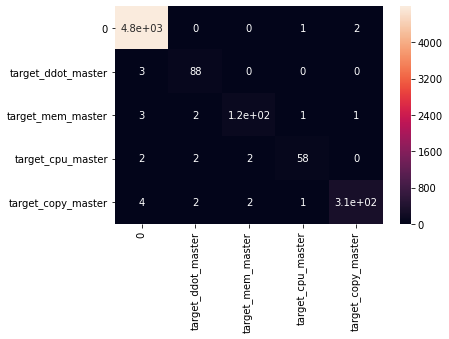

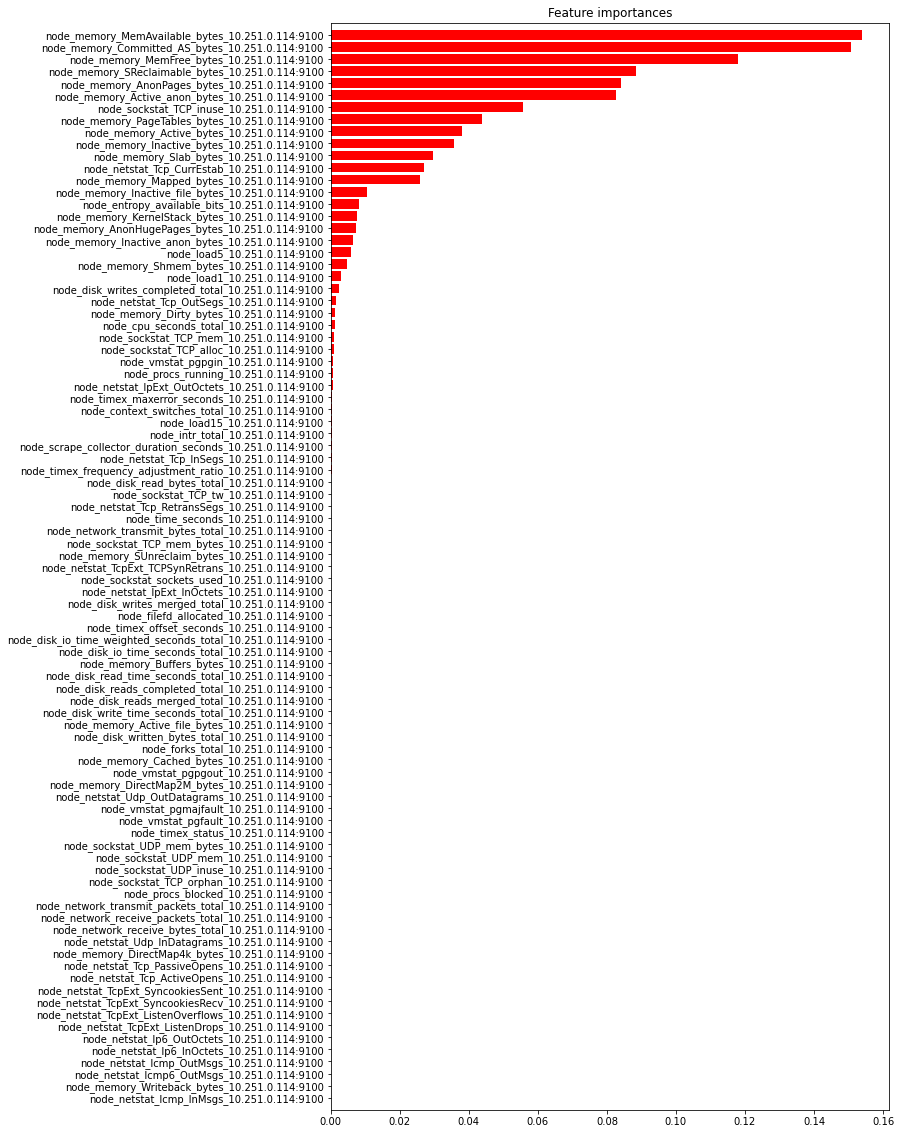

In [113]:
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
cf_fig = "{}_cf.png".format(prefix)
sns_cf.figure.savefig(os.path.join(model_dir, cf_fig))

# Extract Feature importance
feat_importances = pd.Series(cv.best_estimator_.feature_importances_, index=list(data.drop('target', axis=1).columns))
featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
# print(feat_importances.head(10))
sorted_feature = feat_importances.sort_values(ascending=True)
# Plot the feature importances of the forest
# plt.figure()
plt.figure(figsize=(10,20))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), sorted_feature,
       color="r", align="center", )
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), sorted_feature.index)
plt.ylim([-1, X.shape[1]])
plt.show()


Scoring on holdout or other dataset

In [75]:
#Creating the dependent variable class
# factor_h = pd.factorize(df_clean['target'])
# df_clean.target = factor_h[0]
# definitions_h = factor_h[1]

In [85]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_clean.drop('target', axis=1)
# y_h = df_clean['target']

# Scale
# X_h

In [82]:
# X_h = scaler.transform(X_h)


In [83]:
# y_pred_h = cv.best_estimator_.predict(X_h)
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")

In [84]:
# y_pred = cv.best_estimator_.predict(X)
# custom_scoring_reporting(y_pred, y, definitions, prefix)

# jaccard_score(y_h, y_pred_h, average='micro')
# y_pred_h